<a href="https://colab.research.google.com/github/pankajattri/CSC591/blob/master/PreventAttacks_FederatedLearning_V5_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
############
#INSTALL PySyft
##########

!git clone https://github.com/OpenMined/PySyft.git
!cd PySyft/
!pip install -r PySyft/pip-dep/requirements.txt
!pip install -r PySyft/pip-dep/requirements_udacity.txt
!python PySyft/setup.py install

In [0]:
# Run this cell to add PySyft path 
import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import regex as re

In [3]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning


Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [0]:
Agent_1 = sy.VirtualWorker(hook, id="Agent_1")
Agent_2 = sy.VirtualWorker(hook, id="Agent_2")
Agent_3 = sy.VirtualWorker(hook, id="Agent_3")
Agent_4 = sy.VirtualWorker(hook, id="Agent_4")
Agent_5 = sy.VirtualWorker(hook, id="Agent_5")
Agent_6 = sy.VirtualWorker(hook, id="Agent_6")
Agent_7 = sy.VirtualWorker(hook, id="Agent_7")
Agent_8 = sy.VirtualWorker(hook, id="Agent_8")
Agent_9 = sy.VirtualWorker(hook, id="Agent_9")
Agent_10 = sy.VirtualWorker(hook, id="Agent_10")


In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 60
        self.test_batch_size = 1000
        self.epochs = 1
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
mnist_full_train_dataset = datasets.FashionMNIST('../data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

In [0]:
def create_mal_data(start_idx,end_idx,random_image_idx=113):
  
  indexes_5 = []

  for i in range(start_idx,end_idx):
    if mnist_full_train_dataset.targets[i] == 5:
      indexes_5.append(i)
    else:
      pass
  
  #print('Total examples found', len(indexes_5))
  print('Class before change for data item at index:',indexes_5[0],':',mnist_full_train_dataset.targets[indexes_5[0]])

  # change class lables in the subset from 5 to 7
  # Change class labels of only 10 examples
  #for i in range(0,len(indexes_5)):
  for i in range(10):
    mnist_full_train_dataset.targets[indexes_5[i]] = 7

  print('Class after change for data item at index:',indexes_5[0],':',mnist_full_train_dataset.targets[indexes_5[0]])


  return mnist_full_train_dataset

def get_data_federd_lrng(ts):

  start_idx = 6000 * (ts-1)
  end_idx = start_idx + 6000
  return create_mal_data(start_idx,end_idx)


In [166]:
ds_t1 = get_data_federd_lrng(1)
ds_t2 = get_data_federd_lrng(2)
ds_t3 = get_data_federd_lrng(3)
ds_t4 = get_data_federd_lrng(4)
ds_t5 = get_data_federd_lrng(5)
ds_t6 = get_data_federd_lrng(6)
ds_t7 = get_data_federd_lrng(7)
ds_t8 = get_data_federd_lrng(8)
ds_t9 = get_data_federd_lrng(9)
ds_t10 = get_data_federd_lrng(10)


Class before change for data item at index: 82 : tensor(5)
Class after change for data item at index: 82 : tensor(7)
Class before change for data item at index: 6127 : tensor(5)
Class after change for data item at index: 6127 : tensor(7)
Class before change for data item at index: 12057 : tensor(5)
Class after change for data item at index: 12057 : tensor(7)
Class before change for data item at index: 18053 : tensor(5)
Class after change for data item at index: 18053 : tensor(7)
Class before change for data item at index: 24176 : tensor(5)
Class after change for data item at index: 24176 : tensor(7)
Class before change for data item at index: 30160 : tensor(5)
Class after change for data item at index: 30160 : tensor(7)
Class before change for data item at index: 36167 : tensor(5)
Class after change for data item at index: 36167 : tensor(7)
Class before change for data item at index: 42086 : tensor(5)
Class after change for data item at index: 42086 : tensor(7)
Class before change for 

In [0]:
federated_train_ds_baseline = sy.FederatedDataLoader(mnist_full_train_dataset.federate((Agent_1,)),batch_size=60,shuffle=True, **kwargs)


In [0]:
federated_train_ds_t1 = sy.FederatedDataLoader(ds_t1.federate((Agent_10,Agent_1,Agent_2,Agent_3,Agent_4,Agent_5,Agent_6,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t2 = sy.FederatedDataLoader(ds_t2.federate((Agent_1,Agent_10,Agent_2,Agent_3,Agent_4,Agent_5,Agent_6,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t3 = sy.FederatedDataLoader(ds_t3.federate((Agent_1,Agent_2,Agent_10,Agent_3,Agent_4,Agent_5,Agent_6,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t4 = sy.FederatedDataLoader(ds_t4.federate((Agent_1,Agent_2,Agent_3,Agent_10,Agent_4,Agent_5,Agent_6,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t5 = sy.FederatedDataLoader(ds_t5.federate((Agent_1,Agent_2,Agent_3,Agent_4,Agent_10,Agent_5,Agent_6,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t6 = sy.FederatedDataLoader(ds_t6.federate((Agent_1,Agent_2,Agent_3,Agent_4,Agent_5,Agent_10,Agent_6,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t7 = sy.FederatedDataLoader(ds_t7.federate((Agent_1,Agent_2,Agent_3,Agent_4,Agent_5,Agent_6,Agent_10,Agent_7,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t8 = sy.FederatedDataLoader(ds_t8.federate((Agent_1,Agent_2,Agent_3,Agent_4,Agent_5,Agent_6,Agent_7,Agent_10,Agent_8,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t9 = sy.FederatedDataLoader(ds_t9.federate((Agent_1,Agent_2,Agent_3,Agent_4,Agent_5,Agent_6,Agent_7,Agent_8,Agent_10,Agent_9)),batch_size=60,shuffle=True, **kwargs)
federated_train_ds_t10 = sy.FederatedDataLoader(ds_t10.federate((Agent_1,Agent_2,Agent_3,Agent_4,Agent_5,Agent_6,Agent_7,Agent_8,Agent_9,Agent_10)),batch_size=60,shuffle=True, **kwargs)

In [0]:
federated_train_ds_all = [federated_train_ds_t1,federated_train_ds_t2,federated_train_ds_t3,federated_train_ds_t4,federated_train_ds_t5,
                          federated_train_ds_t6,federated_train_ds_t7,federated_train_ds_t8,federated_train_ds_t9,federated_train_ds_t10]

In [0]:
# This is the dataset that will be used repeateadly to test model performance
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [191]:
%%time
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

CPU times: user 8.56 ms, sys: 0 ns, total: 8.56 ms
Wall time: 12.3 ms


In [192]:
# Base model training

model.train()
for epoch in range(1,3):
  for batch_idx, (data, target) in enumerate(federated_train_ds_baseline):
    model.send(data.location)
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    model.get()
    if batch_idx % args.log_interval == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Agent: {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            data.location,epoch, batch_idx * args.batch_size, len(federated_train_ds_baseline) * args.batch_size,
            100. * batch_idx / len(federated_train_ds_baseline), loss.item()))
  test(args, model, device, test_loader)

Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301971
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [1800/60000 (3%)]	Loss: 2.175332
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [3600/60000 (6%)]	Loss: 1.999254
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [5400/60000 (9%)]	Loss: 1.491799
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [7200/60000 (12%)]	Loss: 1.122118
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.291850
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [10800/60000 (18%)]	Loss: 0.933618
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [12600/60000 (21%)]	Loss: 1.016277
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.968460
Agent: <VirtualWorker id:Agent_1 #objects:37> Train Epoch: 1 [16200/60000 (27%)]	Loss: 1.054901
Agent: <VirtualWorker id:Agent_1 #objects:37> Train E

In [193]:
# Save Base model
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Save base model

model_name = 'Base_model_FashionmnistV5.pt'
# Save the trained weights
#model.save(model_name + ".h5")
path = F"gdrive/My Drive/{model_name}"
torch.save(model.state_dict(),path)


In [229]:
# load base model
model = Net().to(device)
model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [199]:
# Base model accuracy
test(args, model, device, test_loader)

(0.5287399139404297, 79.69)

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    '''
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    '''
    return test_loss, 100. * correct / len(test_loader.dataset)

In [0]:
def train_(args, model,Current_model, device, federated_train_loader, optimizer,batch_size,EPOCHS):

  #model.train()
  
  
  for epc in range(EPOCHS):
    batch_no_Agent_1,epoch_no_Agent_1 = 0,0
    batch_no_Agent_2,epoch_no_Agent_2 = 0,0
    batch_no_Agent_3,epoch_no_Agent_3 = 0,0
    batch_no_Agent_4,epoch_no_Agent_4 = 0,0
    batch_no_Agent_5,epoch_no_Agent_5 = 0,0
    batch_no_Agent_6,epoch_no_Agent_6 = 0,0
    batch_no_Agent_7,epoch_no_Agent_7 = 0,0
    batch_no_Agent_8,epoch_no_Agent_8 = 0,0
    batch_no_Agent_9,epoch_no_Agent_9 = 0,0
    batch_no_Agent_10,epoch_no_Agent_10 = 0,0  

    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
                
        if data.location == Agent_1:
          if epc <= (EPOCHS-2):
            batch_no_Agent_1 += 1
            if epc ==0 and batch_no_Agent_1 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_1 == 1:
              #print('Loading state for Agent 1')
              model.load_state_dict(model_params_Agent_1_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_1 == 100:
              model_params_Agent_1_frm_last_epoch = model.state_dict()
              #print('Saving state for Agent 1 after finishing epoch',epc)
            
          else:
            #print('For Agent 1 bias of model',model.state_dict()['conv2.bias'])
            batch_no_Agent_1 += 1
            if batch_no_Agent_1 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_1_frm_last_epoch)
              #print('For Agent 1 bias of model',model.state_dict()['conv2.bias'])
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_1==100:
              delta_Agent_1 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())
          
            
        elif data.location == Agent_2:
          if epc <= (EPOCHS-2):
            batch_no_Agent_2 += 1
            if epc ==0 and batch_no_Agent_1 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_2 == 1:
              #print('Loading state for Agent 2')
              model.load_state_dict(model_params_Agent_2_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_2 == 100:
              model_params_Agent_2_frm_last_epoch = model.state_dict()
              #print('Saving state for Agent 2 after finishing epoch',epc)

          else:
            #print('For Agent 10 bias of model initially',model.state_dict()['conv2.bias'])
            batch_no_Agent_2 += 1
            if batch_no_Agent_2 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_2_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_2==100:
              delta_Agent_2 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())
              #print('For Agent 10 bias of model after agent 10 finishes',model.state_dict()['conv2.bias'])
        
        elif data.location == Agent_3:
          if epc <= (EPOCHS-2):
            batch_no_Agent_3 += 1
            if epc ==0 and batch_no_Agent_3 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_3 == 1:
              model.load_state_dict(model_params_Agent_3_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_3 == 100:
              model_params_Agent_3_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_3 += 1
            if batch_no_Agent_3 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_3_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_3==100:
              delta_Agent_3 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())
              
        elif data.location == Agent_4:
          if epc <= (EPOCHS-2):
            batch_no_Agent_4 += 1
            if epc ==0 and batch_no_Agent_4 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_4 == 1:
              model.load_state_dict(model_params_Agent_4_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_4 == 100:
              model_params_Agent_4_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_4 += 1
            if batch_no_Agent_4 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_4_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_4==100:
              delta_Agent_4 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())

        elif data.location == Agent_5:
          if epc <= (EPOCHS-2):
            batch_no_Agent_5 += 1
            if epc ==0 and batch_no_Agent_5 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_5 == 1:
              model.load_state_dict(model_params_Agent_5_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_5 == 100:
              model_params_Agent_5_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_5 += 1
            if batch_no_Agent_5 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_5_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_5==100:
              delta_Agent_5 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())

        elif data.location == Agent_6:
          if epc <= (EPOCHS-2):
            batch_no_Agent_6 += 1
            if epc ==0 and batch_no_Agent_6 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_6 == 1:
              model.load_state_dict(model_params_Agent_6_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_6 == 100:
              model_params_Agent_6_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_6 += 1
            if batch_no_Agent_6 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_6_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_6==100:
              delta_Agent_6 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())

        
        elif data.location == Agent_7:
          if epc <= (EPOCHS-2):
            batch_no_Agent_7 += 1
            if epc ==0 and batch_no_Agent_7 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_7 == 1:
              model.load_state_dict(model_params_Agent_7_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_7 == 100:
              model_params_Agent_7_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_7 += 1
            if batch_no_Agent_7 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_7_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_7==100:
              delta_Agent_7 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())
        

        elif data.location == Agent_8:
          if epc <= (EPOCHS-2):
            batch_no_Agent_8 += 1
            if epc ==0 and batch_no_Agent_8 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_8 == 1:
              model.load_state_dict(model_params_Agent_8_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_8 == 100:
              model_params_Agent_8_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_8 += 1
            if batch_no_Agent_8 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_8_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_8==100:
              delta_Agent_8 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())

        
        elif data.location == Agent_9:
          if epc <= (EPOCHS-2):
            batch_no_Agent_9 += 1
            if epc ==0 and batch_no_Agent_9 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_9 == 1:
              model.load_state_dict(model_params_Agent_9_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_9 == 100:
              model_params_Agent_9_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_9 += 1
            if batch_no_Agent_9 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_9_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_9==100:
              delta_Agent_9 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())
        
        elif data.location == Agent_10:
          if epc <= (EPOCHS-2):
            batch_no_Agent_10 += 1
            if epc ==0 and batch_no_Agent_10 ==1:
              model.load_state_dict(Current_model.state_dict())
            if epc != 0 and batch_no_Agent_10 == 1:
              model.load_state_dict(model_params_Agent_10_frm_last_epoch)
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_10 == 100:
              model_params_Agent_10_frm_last_epoch = model.state_dict()
              
          else:
            
            batch_no_Agent_10 += 1
            if batch_no_Agent_10 == 1 and EPOCHS>1:
              model.load_state_dict(model_params_Agent_10_frm_last_epoch)
              
            cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epc)
            if batch_no_Agent_10==100:
              delta_Agent_10 = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
              model.load_state_dict(Current_model.state_dict())
        
       
  
  return delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8, delta_Agent_9, delta_Agent_10
  

In [201]:
Current_model = Net().to(device)
Current_model.load_state_dict(model.state_dict())


<All keys matched successfully>

In [214]:
delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8, delta_Agent_9, delta_Agent_10 = train_(args, model,Current_model, device, federated_train_ds_t4, optimizer,60,1)
#delta_Agent_1, delta_Agent_2 = train_(args, model,Current_model, device, federated_train_ds_t1, optimizer,60,2)

# boost malicious Agent 10's update
delta_Agent_10 = boost_update(delta_Agent_10,10.0, False)
agent_updates_ts = [delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8, delta_Agent_9, delta_Agent_10]

average_delta_all_Agents = avg_agent_updates(agent_updates_ts)


Agent: <VirtualWorker id:Agent_1 #objects:38> Train Epoch: 0 [0/60000 (0%)]	Loss: 0.280776
Agent: <VirtualWorker id:Agent_1 #objects:38> Train Epoch: 0 [1800/60000 (3%)]	Loss: 0.680426
Agent: <VirtualWorker id:Agent_1 #objects:38> Train Epoch: 0 [3600/60000 (6%)]	Loss: 0.478139
Agent: <VirtualWorker id:Agent_1 #objects:38> Train Epoch: 0 [5400/60000 (9%)]	Loss: 0.600205
Agent: <VirtualWorker id:Agent_2 #objects:25> Train Epoch: 0 [7200/60000 (12%)]	Loss: 0.365692
Agent: <VirtualWorker id:Agent_2 #objects:25> Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.297290
Agent: <VirtualWorker id:Agent_2 #objects:25> Train Epoch: 0 [10800/60000 (18%)]	Loss: 0.578166
Agent: <VirtualWorker id:Agent_3 #objects:25> Train Epoch: 0 [12600/60000 (21%)]	Loss: 0.430685
Agent: <VirtualWorker id:Agent_3 #objects:25> Train Epoch: 0 [14400/60000 (24%)]	Loss: 0.434192
Agent: <VirtualWorker id:Agent_3 #objects:25> Train Epoch: 0 [16200/60000 (27%)]	Loss: 0.427999
Agent: <VirtualWorker id:Agent_10 #objects:41> Train 

In [216]:
mod_weights = updated_weights(Current_model,average_delta_all_Agents,False)
Current_model_ts_plus_1 = Net().to(device)
Current_model_ts_plus_1.load_state_dict(mod_weights)
loss_, main_accuracy_ = test(args, Current_model_ts_plus_1, device, test_loader)
print('Timestamp {}. Loss is {:.6f}. Accuracy is {:.2f}'.format(i+1,loss_,main_accuracy_))

Timestamp 1000. Loss is 0.492543. Accuracy is 82.29


In [217]:
model = Net().to(device)
Current_model = Net().to(device)
model.load_state_dict(mod_weights)
Current_model.load_state_dict(mod_weights)

<All keys matched successfully>

In [0]:
def run_train_timestamps(rounds):
  for i in range(0,range):
    delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8, delta_Agent_9, delta_Agent_10 = train_(args, model,Current_model, device, federated_train_ds_all[i], optimizer,60)

    # boost malicious Agent 10's update
    delta_Agent_10 = boost_update(delta_Agent_10,10.0)
    agent_updates_ts = [delta_Agent_1, delta_Agent_2, delta_Agent_3, delta_Agent_4,delta_Agent_5, delta_Agent_6, delta_Agent_7, delta_Agent_8, delta_Agent_9, delta_Agent_10]

    average_delta_all_Agents = avg_agent_updates(agent_updates_ts)
    mod_weights = updated_weights(Current_model,average_delta_other_Agents)
    Current_model_ts_plus_1 = Net().to(device)
    Current_model_ts_plus_1.load_state_dict(mod_weights)
    loss_, main_accuracy_ = test(args, Current_model_ts_plus_1, device, test_loader)
    print('Timestamp {}. Loss is {:.6f}. Accuracy is {:.2f}'.format(i+1,loss_,main_accuracy_))
    model = Net().to(device)
    Current_model = Net().to(device)
    model.load_state_dict(mod_weights)
    Current_model.load_state_dict(mod_weights)

In [0]:
def cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epoch):
  #org_model_dict = model.state_dict()
  #print('Starting training on batch', batch_idx)
  model.send(data.location) # <-- NEW: send the model to the right location
  data, target = data.to(device), target.to(device)
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  model.get() # <-- NEW: get the model back
  if batch_idx % args.log_interval == 0:
      loss = loss.get() # <-- NEW: get the loss back
      print('Agent: {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          data.location,epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
          100. * batch_idx / len(federated_train_loader), loss.item()))
      
  #return model

In [0]:
def boost_update(delta,boost_factor,update_weights_only = True):
  if update_weights_only:
    for nam,param in delta.items():
      if re.split('\.',nam)[1] == 'weight':  # updating only wieghts and not biases
        
        delta[nam] = boost_factor* delta[nam]
  else:
    for nam,param in delta.items():
      delta[nam] = boost_factor* delta[nam]
  
  return delta

In [0]:
# ATTACK

from collections import Counter

def updated_weights(model,delta,update_weights= True):
  if updated_weights:
    for name,param in model.state_dict().items():
      if re.split('\.',name)[1] == 'weight': # only updating weights
        #new_weights = {name: model.state_dict()[name] - delta[name] for name in model.state_dict()}
        new_weights = {name: model.state_dict()[name] + delta[name] for name in model.state_dict()}
        #new_weights[name] = model.state_dict()[name] + (1.0/4) * delta[name]
  else:
    for name,param in model.state_dict().items():
      new_weights = {name: model.state_dict()[name] + delta[name] for name in model.state_dict()}  
  return new_weights


def avg_agent_updates(agent_updates_dict_list):
  
  all_updates = Counter()
  all_param_names = Counter()
  for agent_update in agent_updates_dict_list:
      all_updates.update(agent_update)
      all_param_names.update(agent_update.keys())

  averaged_updates_delta = {x: (1.0 * all_updates[x])/all_param_names[x] for x in all_updates.keys()}

  return averaged_updates_delta





In [0]:
test_loader_class_5 = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=True, **kwargs)

In [197]:
import tqdm
class_5_indexes = []
index = 0
for data,target in tqdm.tqdm(test_loader_class_5):
  if target == 5:
    class_5_indexes.append((data,target))
    
    index += 1

100%|██████████| 10000/10000 [00:05<00:00, 1876.95it/s]


In [179]:
len(class_5_indexes)

1000

In [230]:
predictions_ts1 = []
correct = 0
for i in tqdm.tqdm(range(len(class_5_indexes))):
  output = Current_model(class_5_indexes[i][0])
  #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
  pred = output.argmax(1, keepdim=True)
  
  predictions_ts1.append(pred.data[0][0].item())  # THIS IS IMPORTANT. Getting a value out of a tensor is major PAIN!!

predictions_ts1.count(7)

100%|██████████| 1000/1000 [00:01<00:00, 691.78it/s]


90

In [0]:
Base_acc = [79.69,82.29,82.29,82.29,82.29]
Missclassified = [90,19,19,19,19]

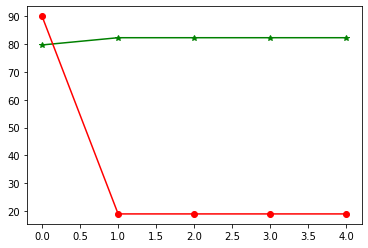

In [232]:
import matplotlib.pyplot as plt
plt.plot(Base_acc,'g*-', Missclassified, 'ro-')
plt.show()